# 基于 NIM 建构多模态 AI-Agent (代码 demo+练习)

本次课程将着重介绍一下内容:

* 多模态模型基于 NIM 的调用方式
* 基于 NIM 接口实现 Phi-3-Vision 的推理实践
* 基于 Gradio 框架建立前端互动界面

## 申请NIM的API Key，来调用NIM的计算资源

进入[ai.nvidia.com](ai.nvidia.com),点击Try Now按钮，选择您要使用的模型并点击，进入后点击**Get API Key**按钮，生成一个秘钥

![](https://v.png.pub/imgs/2024/07/01/72fa333bb5bee55b.png)

# 练习Demo1：基于NIM与langchain实现多模态RAG

### 第一步, 导入工具包

本次实验主要需要三个工具包:

* `langchain_nvidia_ai_endpoint`: 用来调用nvidia nim的计算资源
* `langchain`: 用来构建对话链, 将智能体的各个组件串联起来
* `base64`: 因为本实验是构建多模态的智能体, 需要base64来对图像进行编解码

In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
from langchain.schema.runnable.passthrough import RunnableAssign
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables import RunnablePassthrough

from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

import os
import base64
import matplotlib.pyplot as plt
import numpy as np

将上面准备好自己的API-KEY秘钥粘贴在此处进行替换, 当我们向服务器发送计算请求时, 需要用到

In [2]:
os.environ["NVIDIA_API_KEY"] = ""

查看当前可以使用的模型

In [3]:
ChatNVIDIA.get_available_models()

[Model(id='microsoft/phi-3-vision-128k-instruct', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/vlm/microsoft/phi-3-vision-128k-instruct', aliases=['ai-phi-3-vision-128k-instruct'], supports_tools=False, base_model=None),
 Model(id='ibm/granite-8b-code-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-granite-8b-code-instruct'], supports_tools=False, base_model=None),
 Model(id='google/deplot', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/vlm/google/deplot', aliases=['ai-google-deplot', 'playground_deplot', 'deplot'], supports_tools=False, base_model=None),
 Model(id='google/codegemma-7b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-codegemma-7b'], supports_tools=False, base_model=None),
 Model(id='google/gemma-2-27b-it', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-gemma-2-27b-it'], supports_tools=False, base_model=None),
 Model(id='meta/llama-3.

### 第二步, 利用Microsoft Phi 3 vision 来解析图片数据

将图片进行编解码

In [4]:
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

image_b64 = image2b64("/home/nvidia/aws_hackathon_demo/test.png")
# image_b64 = image2b64("eco-good-bad-chart.png")

查看图片

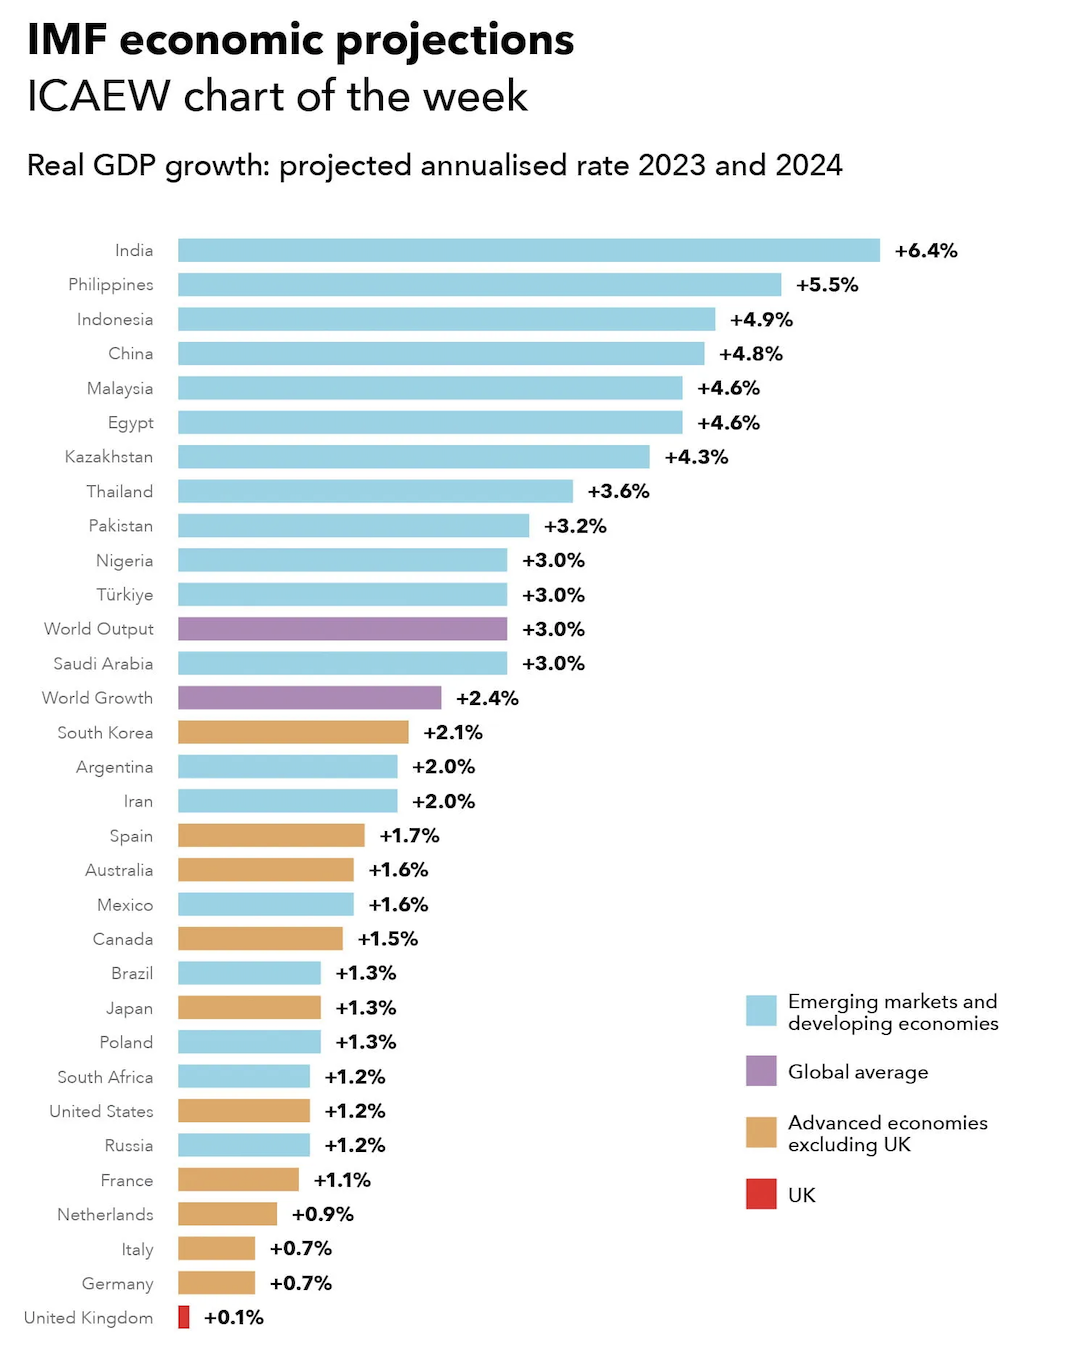

In [5]:
from PIL import Image
display(Image.open("/home/nvidia/aws_hackathon_demo/test.png"))

将编码后的图像按照格式给到Microsoft Phi 3 vision , 利用其强大能力解析图片中的数据

In [6]:
chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />')
print(result.content)

The image contains a bar chart titled "IMF economic projections" which shows the projected annualized rate of Real GDP growth for the year 2023 and 2024 for various countries and regions. The chart is color-coded to differentiate between Emerging markets and developing economies (in blue), Global average (in purple), Advanced economies excluding the UK (in orange), and the UK (in red).

Here is the underlying data table in markdown format:

```markdown
| Country/Region | 2023 Growth | 2024 Growth |
|----------------|-------------|-------------|
| India          | +6.4%       |             |
| Philippines    | +5.5%       |             |
| Indonesia      | +4.9%       |             |
| China          | +4.8%       |             |
| Malaysia       | +4.6%       |             |
| Egypt          | +4.6%       |             |
| Kazakhstan     | +4.3%       |             |
| Thailand       | +3.6%       |             |
| Pakistan       | +3.2%       |             |
| Nigeria        | +3.0%  

In [7]:
test_doc = result.content

In [8]:
test_doc

'The image contains a bar chart titled "IMF economic projections" which shows the projected annualized rate of Real GDP growth for the year 2023 and 2024 for various countries and regions. The chart is color-coded to differentiate between Emerging markets and developing economies (in blue), Global average (in purple), Advanced economies excluding the UK (in orange), and the UK (in red).\n\nHere is the underlying data table in markdown format:\n\n```markdown\n| Country/Region | 2023 Growth | 2024 Growth |\n|----------------|-------------|-------------|\n| India          | +6.4%       |             |\n| Philippines    | +5.5%       |             |\n| Indonesia      | +4.9%       |             |\n| China          | +4.8%       |             |\n| Malaysia       | +4.6%       |             |\n| Egypt          | +4.6%       |             |\n| Kazakhstan     | +4.3%       |             |\n| Thailand       | +3.6%       |             |\n| Pakistan       | +3.2%       |             |\n| Nigeria

In [9]:
with open('/home/nvidia/aws_hackathon_demo/example.txt', 'w', encoding='utf-8') as file:
    # 将字符串写入文件
    file.write(test_doc)

print("字符串已写入文件。")

字符串已写入文件。


### 第三步, 实现RAG检索流程

In [10]:
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss

In [11]:
import os
from tqdm import tqdm
from pathlib import Path

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("/home/nvidia/aws_hackathon_demo/")
data = []
sources = []
for p in ps:
    if p.endswith('.txt'):
        path2file="/home/nvidia/aws_hackathon_demo/"+p
        with open(path2file,encoding="utf-8") as f:
            lines=f.readlines()
            for line in lines:
                if len(line)>=1:
                    data.append(line)
                    sources.append(path2file)

In [12]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0]

(177,
 163,
 'Here comes all the moves of Pikachu, firstly the moves can be learned by leveling up.\n')

In [13]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="NV-Embed-QA")

In [14]:
# 只需要执行一次，后面可以重读已经保存的向量存储
text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
docs = []
metadatas = []

for i, d in enumerate(documents):
    splits = text_splitter.split_text(d)
    #print(len(splits))
    docs.extend(splits)
    metadatas.extend([{"source": sources[i]}] * len(splits))

store = FAISS.from_texts(docs, embedder , metadatas=metadatas)
store.save_local('/home/nvidia/aws_hackathon_demo/nv_embedding')

In [15]:
llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

In [16]:
retriever = store.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("China 2023 Growth？")

"According to the provided context, China's 2023 Growth is +4.8%."

# 练习Demo2,基于NIM与LangChain 构建多模态智能体

**Agent 应用场景**：将图片中的统计图表转换为可以用 python 进行分析的数据

**Agent 工作流**：
- 接收图片，读取图片数据
- 对数据进行调整、分析
- 生成能够绘制图片的代码,并执行代码
- 根据处理后的数据绘制图表

**接收图片 -> 分析数据 -> 修改数据 -> 生成绘制图片的代码 -> 执行代码 -> 展示结果**

#### 辅助函数

这里的函数用于显示输入, 执行代码等, 在我们执行过程中可能会用到

In [17]:
import re

# 将 langchain 运行状态下的表保存到全局变量中
def save_table_to_global(x):
    global table
    if 'TABLE' in x.content:
        table = x.content.split('TABLE', 1)[1].split('END_TABLE')[0]
    return x

# helper function 用于Debug
def print_and_return(x):
    print(x)
    return x

# 对打模型生成的代码进行处理, 将注释或解释性文字去除掉, 留下pyhon代码
def extract_python_code(text):
    pattern = r'```python\s*(.*?)\s*```'
    matches = re.findall(pattern, text, re.DOTALL)
    return [match.strip() for match in matches]

# 执行由大模型生成的代码
def execute_and_return(x):
    code = extract_python_code(x.content)[0]
    try:
        result = exec(str(code))
        #print("exec result: "+result)
    except ExceptionType:
        print("The code is not executable, don't give up, try again!")
    return x

# 将图片编码成base64格式, 以方便输入给大模型
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

### 定义多模态数据分析 Agent

* 这里首先定义了提示词模板, chart_reading_prompt, 我们输入的图片会边恒base64格式的string传输给它
* 将处理好的提示词输入给char_reading, 也就是microsoft/phi-3-vision大模型来进行数据分析, 得到我们需要的表格或者说table变量
* 将Phi3 vision处理好的table和提示词输入给另一个大模型llama3.1, 修改数据并生成代码
* 将生成的代码通过上面的执行函数来执行python代码, 并得到结果

In [18]:
def chart_agent(image_b64, user_input, table):
    # Chart reading Runnable
    chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
    chart_reading_prompt = ChatPromptTemplate.from_template(
        'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />'
    )
    chart_chain = chart_reading_prompt | chart_reading

    # Instruct LLM Runnable
    # instruct_chat = ChatNVIDIA(model="nv-mistralai/mistral-nemo-12b-instruct")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")
    #instruct_chat = ChatNVIDIA(model="ai-llama3-70b")
    instruct_chat = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")

    instruct_prompt = ChatPromptTemplate.from_template(
        "Do NOT repeat my requirements already stated. Based on this table {table}, {input}" \
        "If has table string, start with 'TABLE', end with 'END_TABLE'." \
        "If has code, start with '```python' and end with '```'." \
        "Do NOT include table inside code, and vice versa."
    )
    instruct_chain = instruct_prompt | instruct_chat

    # 根据“表格”决定是否读取图表
    chart_reading_branch = RunnableBranch(
        (lambda x: x.get('table') is None, RunnableAssign({'table': chart_chain })),
        (lambda x: x.get('table') is not None, lambda x: x),
        lambda x: x
    )
    # 根据需求更新table
    update_table = RunnableBranch(
        (lambda x: 'TABLE' in x.content, save_table_to_global),
        lambda x: x
    )
    # 执行绘制图表的代码
    execute_code = RunnableBranch(
        (lambda x: '```python' in x.content, execute_and_return),
        lambda x: x
    )

    chain = (
        chart_reading_branch
        #| RunnableLambda(print_and_return)
        | instruct_chain
        #| RunnableLambda(print_and_return)
        | update_table
        | execute_code
    )

    return chain.invoke({"image_b64": image_b64, "input": user_input, "table": table}).content

### 初始化

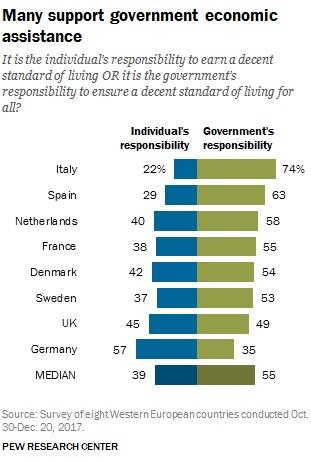

In [19]:
# 使用全局变量 table 来存储数据
table = None
# 将要处理的图像转换成base64格式
image_b64 = image2b64("/home/nvidia/aws_hackathon_demo/economic-assistance-chart.png")

#展示读取的图片
from PIL import Image

display(Image.open("/home/nvidia/aws_hackathon_demo/economic-assistance-chart.png"))

### 执行上面构建好的智能体

#### 先将图片的数据转为字符串

In [20]:
user_input = "show this table in string"
chart_agent(image_b64, user_input, table)
print(table)    # let's see what 'table' looks like now



| Country | Individuals (%) | Government (%) |
| --- | --- | --- |
| Italy | 22% | 74% |
| Spain | 29% | 63% |
| Netherlands | 40% | 58% |
| France | 38% | 55% |
| Denmark | 42% | 54% |
| Sweden | 37% | 53% |
| UK | 45% | 49% |
| Germany | 57% | 35% |
| Median | 39% | 55% |




#### 让 Agent 自己尝试修改其中的内容

比如我们这里要把所有的UK 替换成United Kingdom

In [21]:
user_input = "replace table string's 'Netherlands' with 'Holland'"
chart_agent(image_b64, user_input, table)
print(table)    # let's see what 'table' looks like now


| Country | Individuals (%) | Government (%) |
| --- | --- | --- |
| Italy | 22% | 74% |
| Spain | 29% | 63% |
| Holland | 40% | 58% |
| France | 38% | 55% |
| Denmark | 42% | 54% |
| Sweden | 37% | 53% |
| UK | 45% | 49% |
| Germany | 57% | 35% |
| Median | 39% | 55% |



#### 用 python 绘制图表

这里会让大模型生成绘制图像的代码, 并执行生成的代码

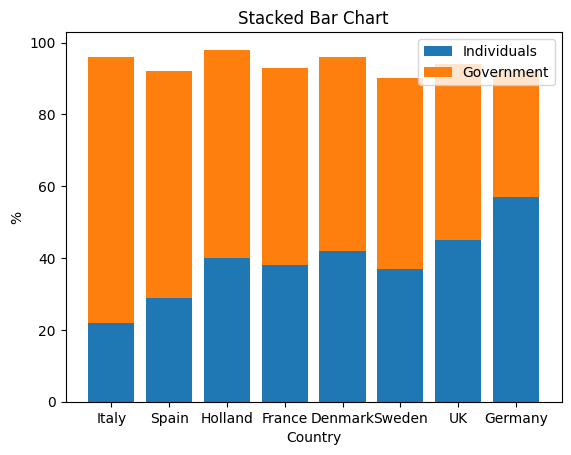

result: ```python
import matplotlib.pyplot as plt
import numpy as np

# Data
countries = ['Italy', 'Spain', 'Holland', 'France', 'Denmark', 'Sweden', 'UK', 'Germany']
individuals = [22, 29, 40, 38, 42, 37, 45, 57]
government = [74, 63, 58, 55, 54, 53, 49, 35]

# Create a stacked bar chart
plt.bar(countries, individuals, label='Individuals')
plt.bar(countries, government, bottom=individuals, label='Government')

# Set labels and title
plt.xlabel('Country')
plt.ylabel('%')
plt.title('Stacked Bar Chart')
plt.legend()

# Show the plot
plt.show()
```


In [22]:
user_input = "draw this table as stacked bar chart in python"
result = chart_agent(image_b64, user_input, table)
print("result: "+result)  # let's see what 'table' looks like now

## 第四步, 将多模态智能体封装进Gradio

当我们完成上述任务的时候, 就拥有了一个可以分析图片, 生成代码, 修改数据, 执行代码的智能体

接下来我们给这个智能体添加一个UI界面, 让我们可以更舒服的与之对话

我们修改一下执行代码的函数, 因为原生的Python中exec函数的返回是Nan, 所以我们给他添加一个生成图片的路径

在下面的代码中, 路径是作者的PC中的路径, 请您根据您自己的系统更换这个文件夹路径

In [23]:
global img_path
img_path = '/home/nvidia/aws_hackathon_demo/'+'image.png'
print(img_path)

/home/nvidia/aws_hackathon_demo/image.png


In [24]:
def execute_and_return_gr(x):
    code = extract_python_code(x.content)[0]
    try:
        result = exec(str(code))
        #print("exec result: "+result)
    except ExceptionType:
        print("The code is not executable, don't give up, try again!")
    return img_path

In [25]:
def chart_agent_gr(image_b64, user_input, table):

    image_b64 = image2b64(image_b64)
    # Chart reading Runnable
    chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
    chart_reading_prompt = ChatPromptTemplate.from_template(
        'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />'
    )
    chart_chain = chart_reading_prompt | chart_reading

    # Instruct LLM Runnable
    # instruct_chat = ChatNVIDIA(model="nv-mistralai/mistral-nemo-12b-instruct")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")
    #instruct_chat = ChatNVIDIA(model="ai-llama3-70b")
    #instruct_chat = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")
    instruct_chat = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")

    instruct_prompt = ChatPromptTemplate.from_template(
        "Do NOT repeat my requirements already stated. Based on this table {table}, {input}" \
        "If has table string, start with 'TABLE', end with 'END_TABLE'." \
        "If has code, start with '```python' and end with '```'." \
        "Do NOT include table inside code, and vice versa."
    )
    instruct_chain = instruct_prompt | instruct_chat

    # 根据“表格”决定是否读取图表
    chart_reading_branch = RunnableBranch(
        (lambda x: x.get('table') is None, RunnableAssign({'table': chart_chain })),
        (lambda x: x.get('table') is not None, lambda x: x),
        lambda x: x
    )
    
    # 根据需求更新table
    update_table = RunnableBranch(
        (lambda x: 'TABLE' in x.content, save_table_to_global),
        lambda x: x
    )

    execute_code = RunnableBranch(
        (lambda x: '```python' in x.content, execute_and_return_gr),
        lambda x: x
    )
    
    # 执行绘制图表的代码
    chain = (
        chart_reading_branch
        #| RunnableLambda(print_and_return)
        | instruct_chain
        #| RunnableLambda(print_and_return)
        | update_table
        | execute_code
    )

    return chain.invoke({"image_b64": image_b64, "input": user_input, "table": table})

这里是示意提示词, 方便大家打开Gradio页面时候直接复制粘贴

In [26]:
user_input = "replace table string's 'Netherlands' with 'Holland'', draw this table as stacked bar chart in python, and save the image in path: "+img_path
print(user_input)

replace table string's 'Netherlands' with 'Holland'', draw this table as stacked bar chart in python, and save the image in path: /home/nvidia/aws_hackathon_demo/image.png


执行上述代码, 将打开一个Gradio的服务, 我们可以利用Gradio的页面与构建好的智能体对话

注意: 以下代码是打开gradio的后端服务，前端页面的展示是需要新开一个浏览器窗口通过输入ip地址：http://36.150.110.74 和对应的端口号如：9597 即 http://36.150.110.74:9597/ 进行前端演示
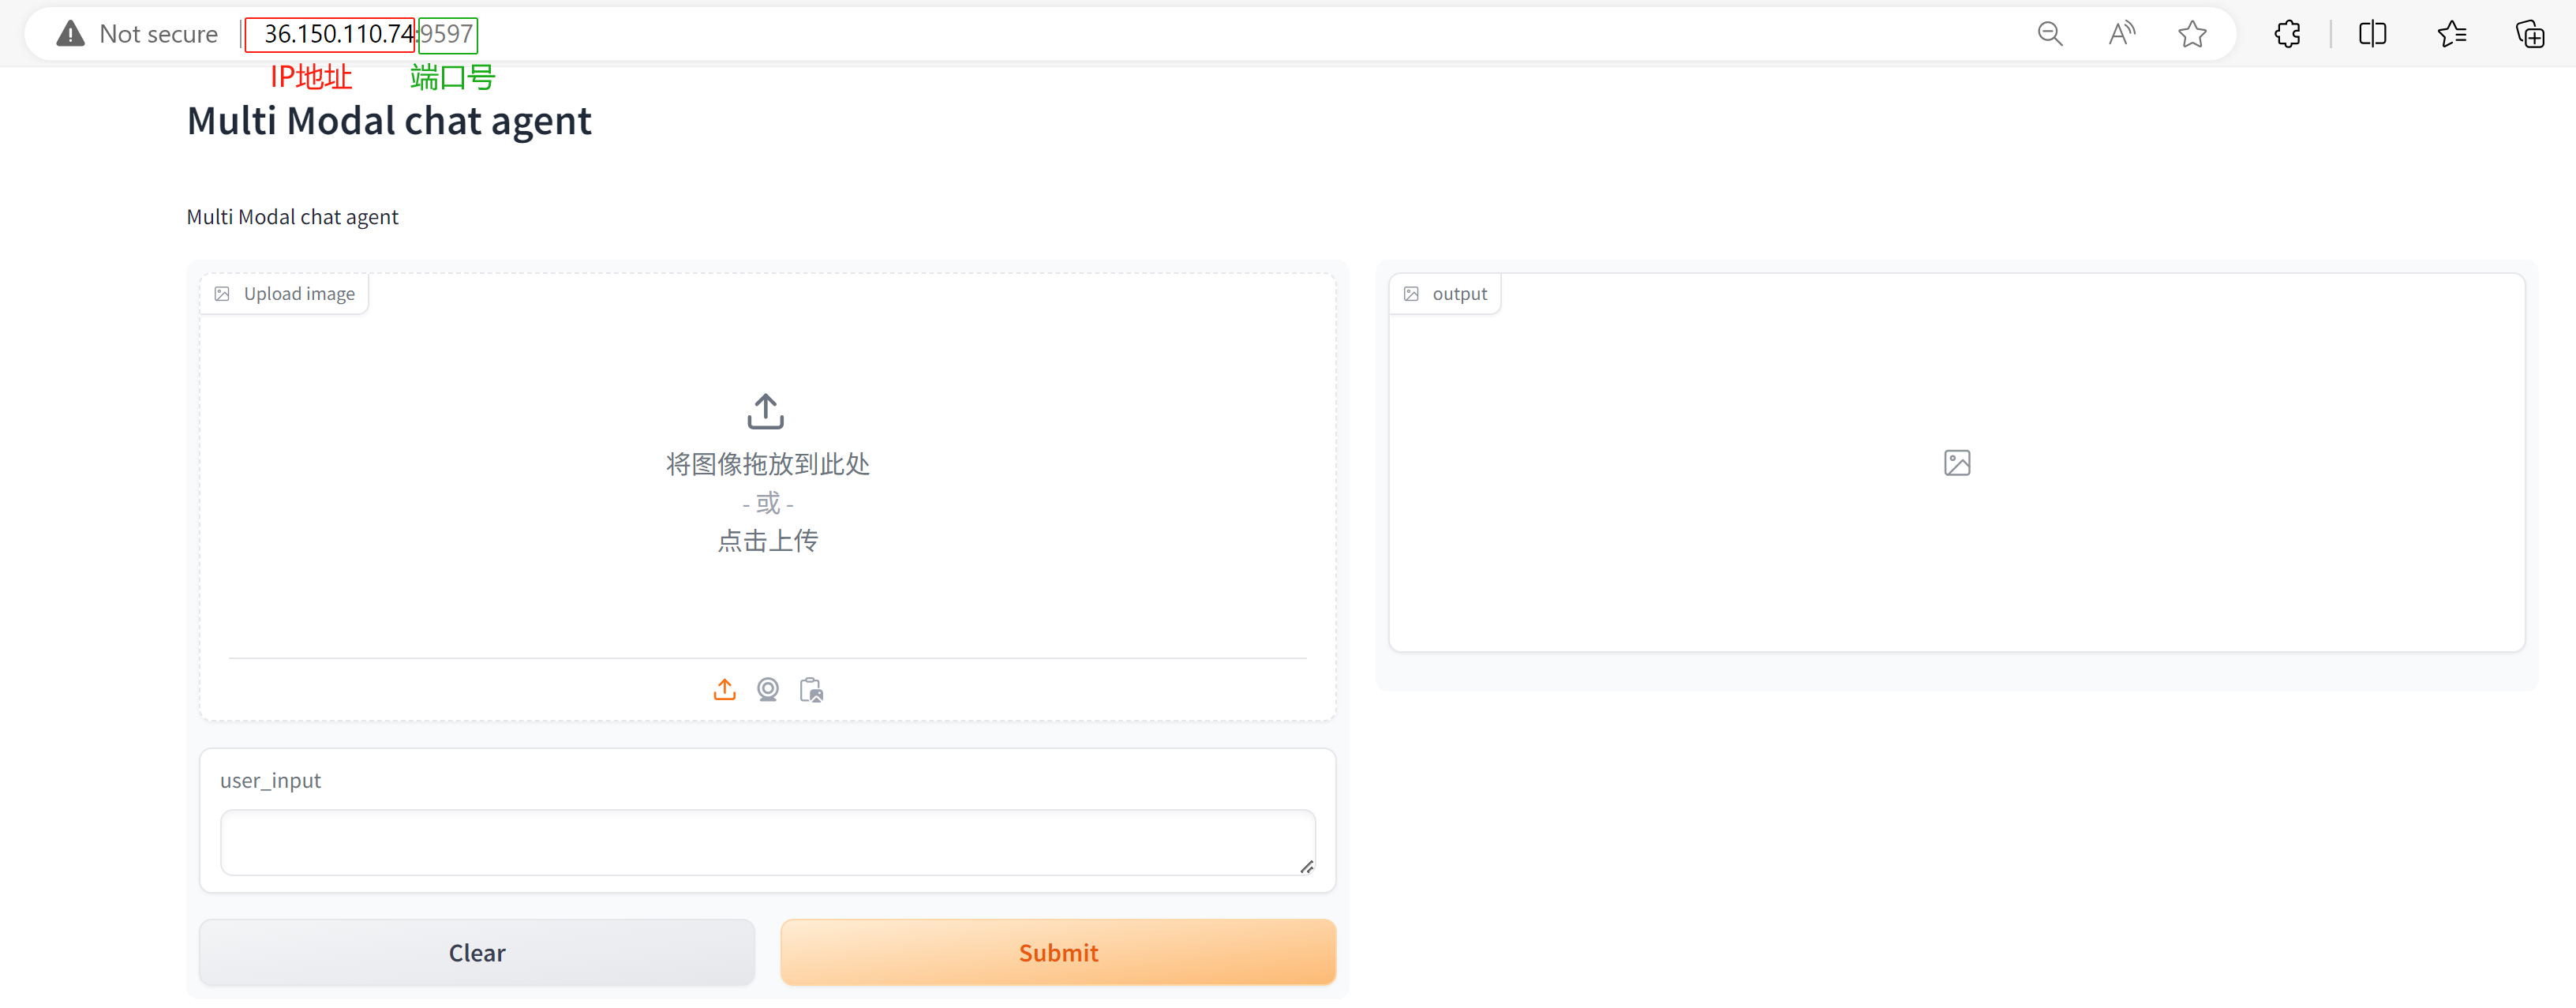

举例：如果您在Jetson节点中的端口号是9910，那么前端所对应的ip及端口就是：http://36.150.110.74:9510/

In [ ]:
import gradio as gr
multi_modal_chart_agent = gr.Interface(fn=chart_agent_gr,
                    inputs=[gr.Image(label="Upload image", type="filepath"), 'text'],
                    outputs=['image'],
                    title="Multi Modal chat agent",
                    description="Multi Modal chat agent",
                    allow_flagging="never")

multi_modal_chart_agent.launch(debug=True, share=False, show_api=False, server_port=5000, server_name="0.0.0.0")

/home/nvidia/.local/lib/python3.8/site-packages/gradio/utils.py:985: UserWarning: Expected 3 arguments for function <function chart_agent_gr at 0xffff5c02d280>, received 2.
  warnings.warn(
/home/nvidia/.local/lib/python3.8/site-packages/gradio/utils.py:989: UserWarning: Expected at least 3 arguments for function <function chart_agent_gr at 0xffff5c02d280>, received 2.
  warnings.warn(


Running on local URL:  http://0.0.0.0:5000
IMPORTANT: You are using gradio version 4.31.1, however version 4.44.1 is available, please upgrade.
--------

To create a public link, set `share=True` in `launch()`.


### 最终结果前端展示
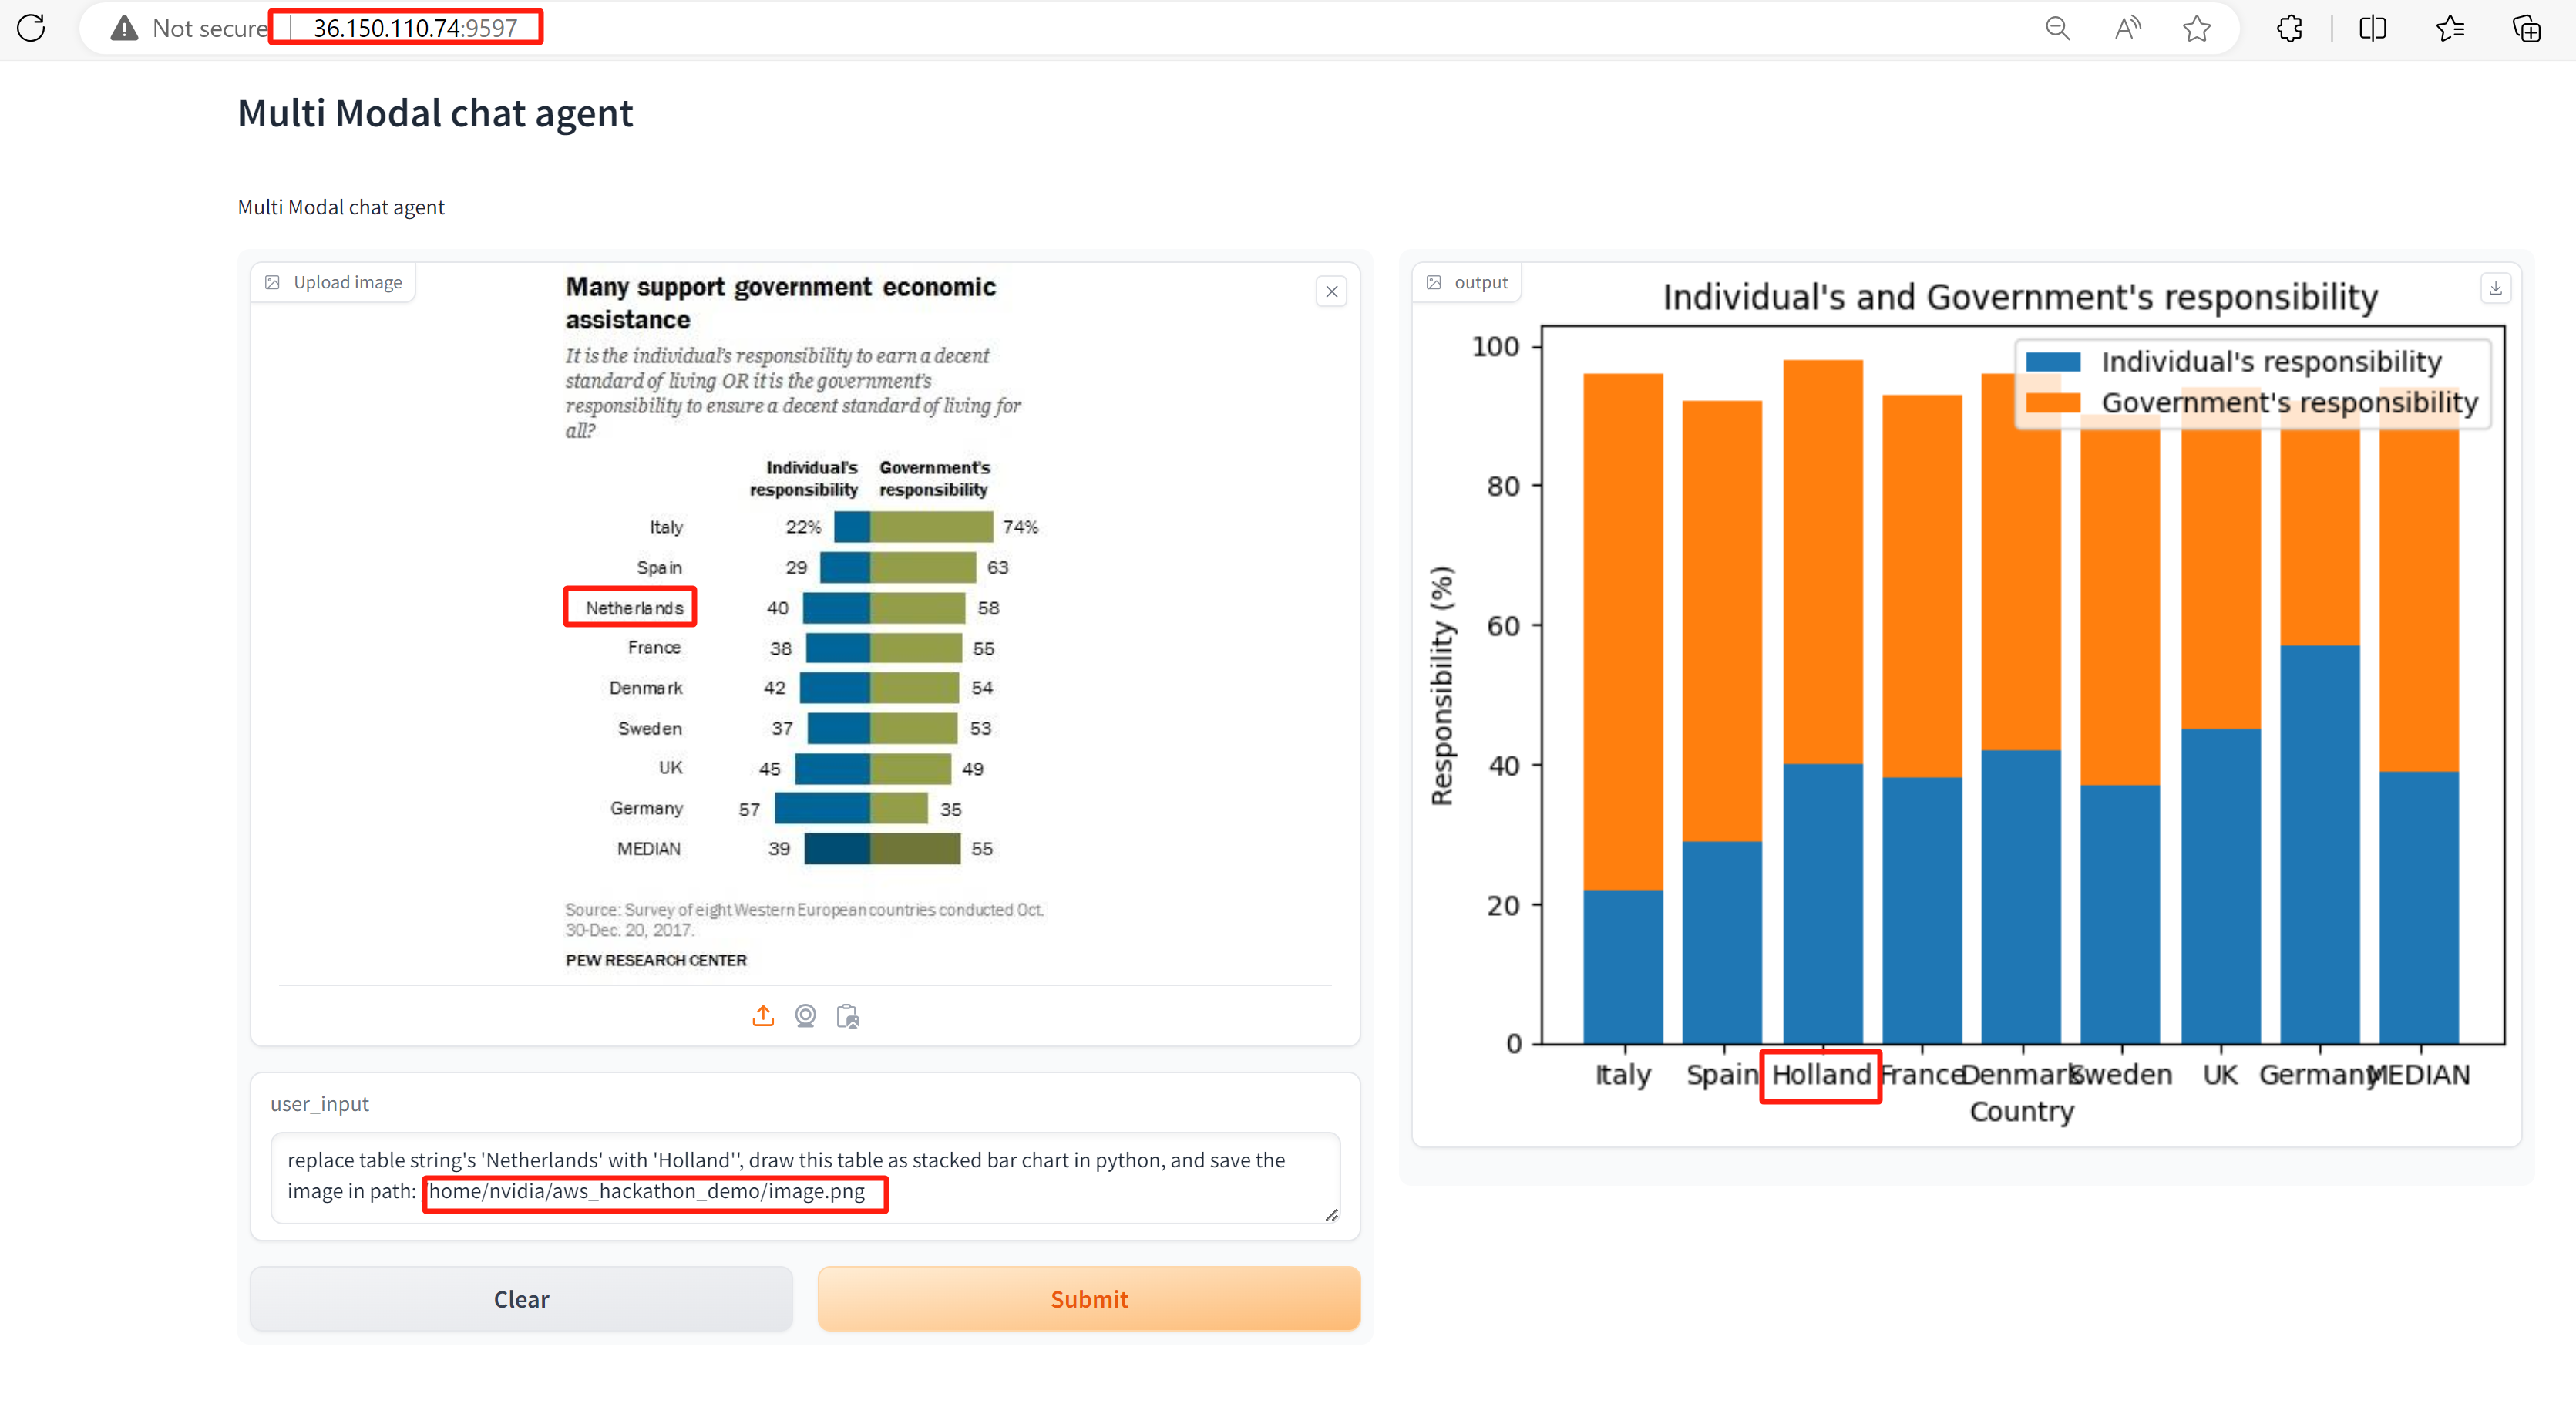